In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

# 加载表达矩阵（示例数据）
data = pd.read_csv("./data/yellow_moduel_final_expression_matrix_protein_coding_genes.csv", index_col=0)  # 基因名为列名

In [2]:
data=data[['UBE2C','TPX2','FOXM1','E2F1','CEP55','NEK2','CDCA8','CDK1','CCNB1','CKS2']]

In [3]:
genes = data.columns.tolist()
X = data.values  # 转为numpy数组 (n_samples, n_genes)
print(f"表达矩阵形状: {X.shape}")

表达矩阵形状: (1173, 10)


In [4]:
from minepy import MINE

def compute_mi_matrix(X, genes):
    n_genes = len(genes)
    mi_matrix = np.zeros((n_genes, n_genes))
    
    mine = MINE(alpha=0.6, c=15)  # 参数调节敏感度
    
    for i in range(n_genes):
        for j in range(i+1, n_genes):  # 仅计算上三角
            mine.compute_score(X[:, i], X[:, j])
            mi_matrix[i, j] = mine.mic()  # MIC (Maximal Information Coefficient)
            mi_matrix[j, i] = mi_matrix[i, j]  # 对称矩阵
    
    return pd.DataFrame(mi_matrix, index=genes, columns=genes)

mi_matrix = compute_mi_matrix(X, genes)
mi_matrix.to_csv("mi_matrix.csv")  # 保存结果

In [5]:
def build_grn(mi_matrix, threshold=0.95):
    # 方法1：按分位数阈值
    threshold_value = np.percentile(mi_matrix.values.flatten(), threshold * 100)
    adj_matrix = (mi_matrix >= threshold_value).astype(int)
    
    # 方法2：可改用统计检验（如置换检验生成背景分布）
    
    np.fill_diagonal(adj_matrix.values, 0)  # 去除自环
    return adj_matrix

adj_matrix = build_grn(mi_matrix, threshold=0.65)

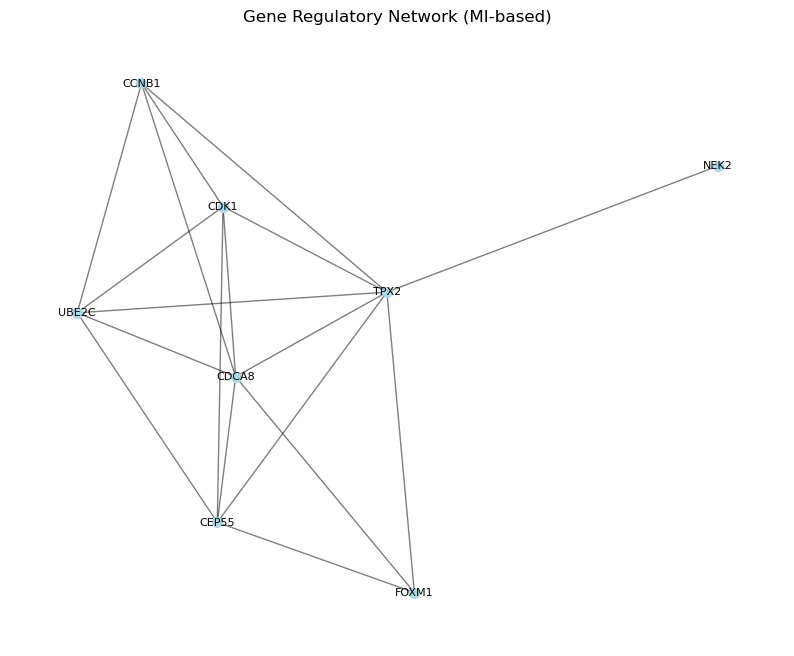

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_grn(adj_matrix, genes, top_k=50):
    # 提取Top K边
    edges = []
    for i in range(len(genes)):
        for j in range(i+1, len(genes)):
            if adj_matrix.iloc[i, j] > 0:
                edges.append((genes[i], genes[j], adj_matrix.iloc[i, j]))
    edges.sort(key=lambda x: x[2], reverse=True)
    edges = edges[:top_k]
    
    # 构建图
    G = nx.Graph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])
    
    # 绘制
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.15)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Gene Regulatory Network (MI-based)")
    plt.axis('off')
    plt.show()

plot_grn(adj_matrix, genes)

In [7]:
def show_ROC(label,pred):   #显示ROC曲线
    fpr,tpr,threshold = roc_curve(label, pred) ###计算真正率和假正率
    roc_auc=auc(fpr,tpr)###计算auc的值
    
    plt.figure()
    lw = 2
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig ("ROC.png",dpi=300) 
    plt.show() 

In [9]:
label=[0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1]

In [10]:
pred=[0.761955618,0.625853993,0.660153883,0.559649361,0.681031558,0.669019489,0.659250393,0.569223849,0.75371142,0.746768556,0.651088784,0.758887134,0.724165374,0.71346936,0.528428565,0.73411225,0.615132514,0.680621846,0.618496849,0.59908832,0.451067594,0.624904652,0.706866414,0.719416661,0.631287231,0.502575471,0.597459791,0.627054296,0.596058149,0.466378884,0.653904991,0.634572616,0.499370853,0.665840547,0.553297612,0.557547702]

<Figure size 640x480 with 0 Axes>

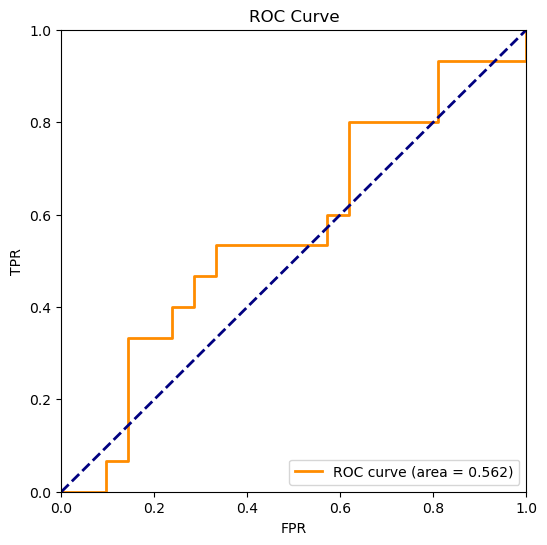

In [11]:
show_ROC(label,pred)